# Статистика ускорения: исследование данных сервиса GoFast
## Цель
Проект посвящён статистическому анализу данных для сервиса аренды самокатов GoFast, который предоставляет пользователям возможность арендовать самокаты через мобильное приложение. Цель исследования — изучить поведение пользователей, выявить ключевые тенденции и проверить гипотезы, которые могут способствовать развитию бизнеса и увеличению доходности.

Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:
*   без подписки
  *   абонентская плата отсутствует;
  *   стоимость одной минуты поездки — 8 рублей;
  *   стоимость старта (начала поездки) — 50 рублей;

*   с подпиской Ultra
  *   абонентская плата — 199 рублей в месяц;
  *   стоимость одной минуты поездки — 6 рублей;
  *   стоимость старта — бесплатно.

## Шаги
В рамках проекта будут выполнены следующие шаги:

1.   **Загрузка данных**: Данные о пользователях, их поездках и подписках будут загружены из предоставленных источников и преобразованы в удобный для анализа формат.

2.   **Предобработка данных**: Будут проверены и обработаны пропуски и дубликаты, а также произведена подготовка данных (например, преобразование формата даты).

3.   **Исследовательский анализ данных**: Выполняется анализ характеристик пользователей и поездок, включая частоту встречаемости городов, распределение подписок, возрастные группы, расстояние и продолжительность поездок.

4.   **Объединение данных**: Данные о пользователях, поездках и подписках будут объединены для получения целостной картины. Также будут выделены отдельные категории данных для подписчиков и пользователей без подписки.

5.   **Подсчёт выручки**: Расчёт помесячной выручки от пользователей с учётом особенностей оплаты для подписчиков и тех, кто использует сервис без подписки.

6.   **Проверка гипотез**: Проведение статистических тестов для ответа на ключевые вопросы:
  *   Тратят ли подписчики больше времени на поездки?
  *   Превышает ли средняя длина поездки подписчиков оптимальную для оборудования?
  *   Превышает ли помесячная выручка от подписчиков выручку от пользователей без подписки?

7.   **Анализ распределений**: Определение минимального количества промокодов для обеспечения выполнения маркетинговых целей и оценка вероятности открытия push-уведомлений.

## Описание данных

**Пользователи**
*   `user_id` - уникальный идентификатор пользователя
*   `name` - имя пользователя
*   `age` - возраст
*   `city` - город
*   `subscription_type` - тип подписки (free, ultra)

**Поездки**
*   `user_id` - уникальный идентификатор пользователя
*   `distance` - расстояние, которое пользователь проехал в текущей сессии (в метрах)
*   `duration` - продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
*   `date` - дата совершения поездки

**Подписки**
*   `subscription_type` - тип подписки
*   `minute_price` - стоимость одной минуты поездки по данной подписке
*   `start_ride_price` - стоимость начала поездки
*   `subscription_fee` - стоимость ежемесячного платежа

# Загрузка данных и подготовка их к анализу

In [ ]:
# Импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy.stats import ttest_ind
from scipy.stats import binom
from scipy.stats import norm
from scipy.stats import ttest_1samp

In [ ]:
# Загрузка данных
try:
    # Попытка прочитать файл из Google Drive
    path = '/content/drive/MyDrive/Colab Notebooks/Обучение/Яндекс Практикум/Аналитик данных (расширенный)/Dataset/stat_data_analysis/'
    df_users = pd.read_csv(path + 'users_go.csv')
    df_rides = pd.read_csv(path + 'rides_go.csv')
    df_subs = pd.read_csv(path + 'subscriptions_go.csv')
except FileNotFoundError:
    # Если файлы не найдены, загрузка с сервера Yandex
    print("Файлы не найдены на Google Drive, загрузка с сервера Yandex")
    try:
        df_users = pd.read_csv('https://code.s3.yandex.net/datasets/users_go.csv')
        df_rides = pd.read_csv('https://code.s3.yandex.net/datasets/rides_go.csv')
        df_subs = pd.read_csv('https://code.s3.yandex.net/datasets/subscriptions_go.csv')
    except Exception as e:
        # Обработка ошибок при загрузке с сервера Yandex
        print(f"Ошибка при загрузке файлов с сервера: {e}")

In [ ]:
# Функция для обзора данных
def data_review(data):
    display(data.head())
    print('------------------------------------------------------------------------------------------------')
    print(data.info())
    print('------------------------------------------------------------------------------------------------')
    print(data.isnull().sum())
    print('------------------------------------------------------------------------------------------------')
    print(data.duplicated().sum())

## Изучение данных
Изучение данных датафреймов с пользователями, поездками и подписками.

In [ ]:
# Обзор данных в датафрейме 'users_go'
data_review(df_users)

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB
None
------------------------------------------------------------------------------------------------
user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64
------------------------------------------------------------------------------------------------
31


### Результаты анализа данных с пользователями
*   **Пропуски**: Пропусков в данных нет.
*   **Дубликаты**: В данных обнаружен 31 дубликат - их необходимо удалить.
*   **Типы данных**: Все типы данных корректны.
  

In [ ]:
# Обзор данных в датафрейме 'rides_go'
data_review(df_rides)

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB
None
------------------------------------------------------------------------------------------------
user_id     0
distance    0
duration    0
date        0
dtype: int64
------------------------------------------------------------------------------------------------
0


### Результаты анализа данных с поездками
*   **Пропуски**: Пропусков в данных нет.
*   **Дубликаты**: Дубликатов в данных нет.
*   **Типы данных**: Столбец `date` имеет тип данных 'object' - необходимо преобразовать в формат 'datetime' для корректной работы с датами.

In [ ]:
# Обзор данных в датафрейме 'subscriptions_go'
data_review(df_subs)

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes
None
------------------------------------------------------------------------------------------------
subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64
------------------------------------------------------------------------------------------------
0


### Результаты анализа данных с подписками
*   **Пропуски**: Пропусков в данных нет.
*   **Дубликаты**: Дубликатов в данных нет.
*   **Типы данных**: Все типы данных корректны.

## Предобработка данных

In [ ]:
# Удаление дубликатов из датафрейма df_users
df_users = df_users.drop_duplicates()

# Преобразование столбца 'date' в datetime в df_rides
df_rides['date'] = pd.to_datetime(df_rides['date'])

# Создание нового столбца с номером месяца на основе столбца 'date' в df_rides
df_rides['month'] = df_rides['date'].dt.month

In [ ]:
# Проверяем период, за который имеются данные в датафрейме df_rides
date_range = df_rides['date'].min(), df_rides['date'].max()

date_range

(Timestamp('2021-01-01 00:00:00'), Timestamp('2021-12-30 00:00:00'))

Данные о поездках охватывают период с 1 января 2021 года по 30 декабря 2021 года.

## Заключение

На данном этапе были загружены три датафрейма: `df_users` (информация о пользователях), `df_rides` (данные о поездках) и `df_subs` (данные о подписках). Все таблицы не содержат пропусков, однако в `df_users` были обнаружены дубликаты, которые были удалены. В таблице `df_rides` был преобразован столбец 'date' в формат datetime, а также добавлен новый столбец с номером месяца. В таблице `df_subs` проблем с данными не выявлено.

# Исследовательский анализ данных

## Город пользователей

<ipython-input-39-6d77c041a36e>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=city_counts.index, x=city_counts.values, palette='deep')


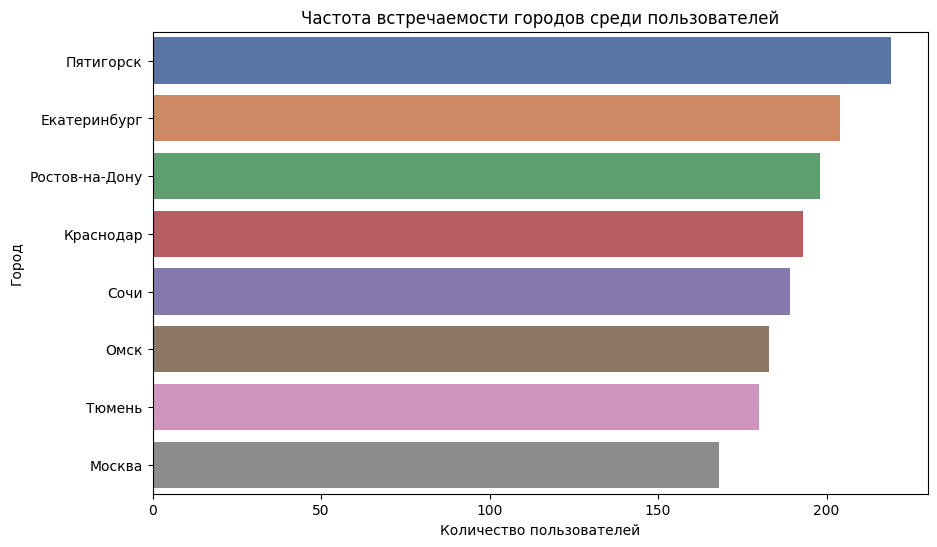

,count
city,
Пятигорск,219
Екатеринбург,204
Ростов-на-Дону,198
Краснодар,193
Сочи,189
Омск,183
Тюмень,180
Москва,168


In [ ]:
# Подсчёт количества пользователей в каждом городе
city_counts = df_users['city'].value_counts().sort_values(ascending=False)

# Построение столбчатой диаграммы
plt.figure(figsize=(10, 6))
sns.barplot(y=city_counts.index, x=city_counts.values, palette='deep')
plt.title('Частота встречаемости городов среди пользователей')
plt.xlabel('Количество пользователей')
plt.ylabel('Город')
plt.show()

# Отображение данных в табличном виде
city_counts

Из визуализации видно, что наибольшее количество пользователей наблюдается в Пятигорске, а наименьшее — в Москве.

## Использование подписки

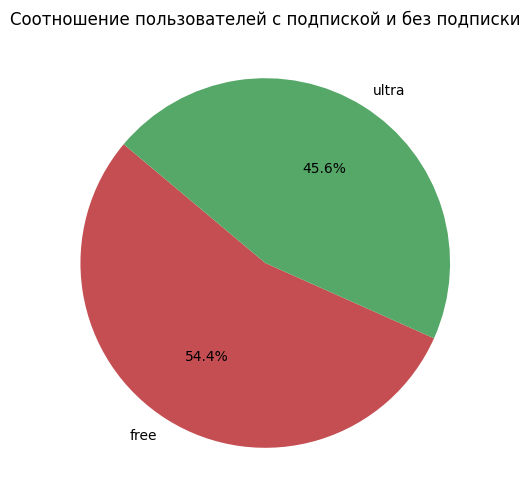

In [ ]:
# Подсчёт количества пользователей с подпиской и без подписки
subs_counts = df_users['subscription_type'].value_counts()

# Построение диаграммы для соотношения пользователей с подпиской и без подписки
plt.figure(figsize=(6, 6))
plt.pie(subs_counts, labels=subs_counts.index, autopct='%1.1f%%', startangle=140, colors=['#c44e52', '#55a868'])
plt.title('Соотношение пользователей с подпиской и без подписки')
plt.show()

Из визуализации видно, что большинство пользователей (54.4%) пользуются сервисом без подписки, в то время как 45.6% имеют подписку.

## Возраст пользователей

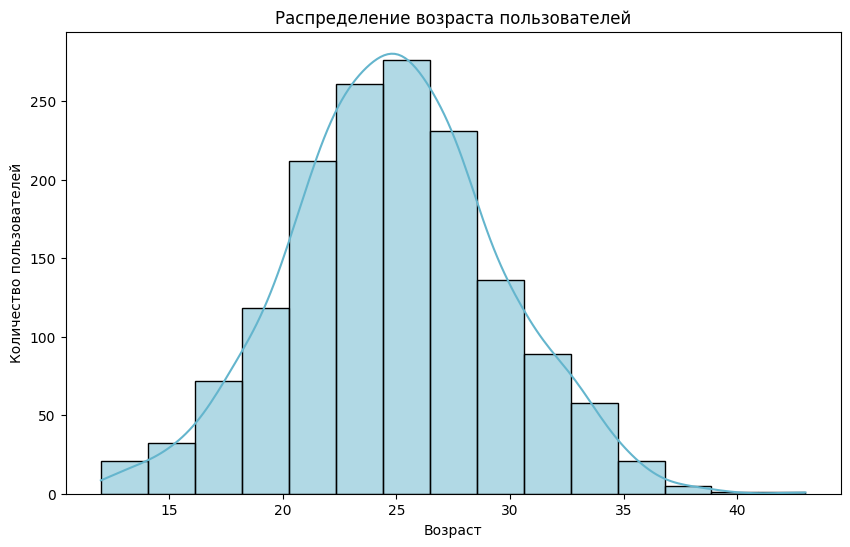

,age
count,1534.000000
mean,24.903520
std,4.572367
min,12.000000
25%,22.000000
50%,25.000000
75%,28.000000
max,43.000000


In [ ]:
# Построение гистограммы для распределения возраста пользователей
plt.figure(figsize=(10, 6))
sns.histplot(df_users['age'], bins=15, kde=True, color='#64b5cd')
plt.title('Распределение возраста пользователей')
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')
plt.show()

# Дополнительный анализ с использованием describe()
age_description = df_users['age'].describe()
age_description

Из визуализации видно, что большинство пользователей находятся в возрасте от 20 до 30 лет, с пиком около 25 лет.

## Расстояние поездки

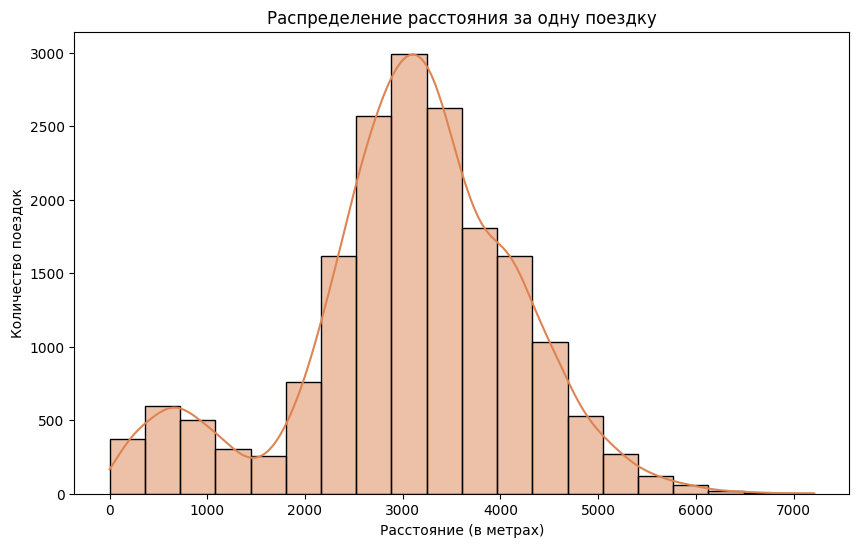

In [ ]:
# Построение гистограммы для распределения расстояния, которое пользователи преодолевают за одну поездку
plt.figure(figsize=(10, 6))
sns.histplot(df_rides['distance'], bins=20, kde=True, color='#dd8452')
plt.title('Распределение расстояния за одну поездку')
plt.xlabel('Расстояние (в метрах)')
plt.ylabel('Количество поездок')
plt.show()

Из визуализации видно, что большинство поездок покрывают расстояние около 3 км.

## Время поездки

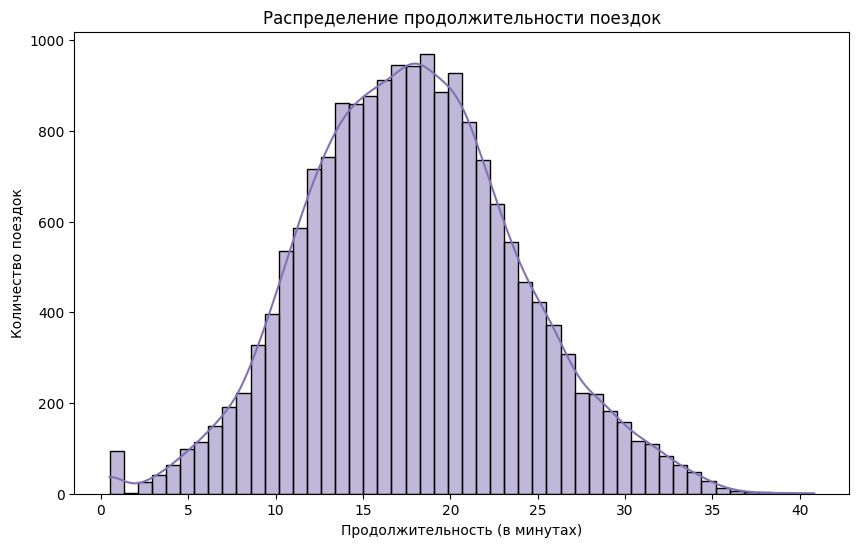

In [ ]:
# Построение гистограммы для распределения продолжительности поездок
plt.figure(figsize=(10, 6))
sns.histplot(df_rides['duration'], bins=50, kde=True, color='#8172b3')
plt.title('Распределение продолжительности поездок')
plt.xlabel('Продолжительность (в минутах)')
plt.ylabel('Количество поездок')
plt.show()

Из визуализации видно, что основная часть поездок длится около 15–20 минут.

In [ ]:
# Отбор и отображение поездок с аномальной продолжительностью (около 0 минут)
df_anomal_duration = df_rides[df_rides['duration'] <= 1]
df_anomal_duration

,user_id,distance,duration,date,month
6531,701,4196.445201,0.5,2021-08-31,8
6570,704,4830.824371,0.5,2021-10-14,10
6680,712,4684.004397,0.5,2021-03-04,3
6695,713,5215.642710,0.5,2021-02-25,2
6768,718,5197.436649,0.5,2021-02-11,2
...,...,...,...,...,...
17004,1460,5531.335845,0.5,2021-01-19,1
17242,1477,6724.932981,0.5,2021-01-12,1
17314,1483,4445.481070,0.5,2021-03-06,3
17505,1496,5722.551787,0.5,2021-02-14,2


Несмотря на минимальную продолжительность (0.5 минуты), расстояние, которое преодолевают пользователи, значительно варьируется (от ~4000 до ~5200 метров). Это несоответствие предполагает, что либо данные о продолжительности некорректны, либо что-то необычное произошло во время поездки (например, сбой в приложении или трекинге GPS). Исключим поездки с малой продолжительностью (менее 1 минуты) из дальнейшего анализа.

In [ ]:
# Исключение поездок с продолжительностью менее 1 минуты
df_rides = df_rides[df_rides['duration'] >= 1]

## Заключение

В ходе исследования данных мы установили, что наибольшее количество пользователей сервиса GoFast проживает в Пятигорске, а наименьшее — в Москве. Большинство клиентов (54.4%) предпочитают пользоваться сервисом без подписки, тогда как 45.6% имеют подписку. Основная возрастная группа пользователей — от 20 до 30 лет, с пиком около 25 лет. Анализ данных о поездках показал, что средняя дистанция, преодолеваемая за одну поездку, составляет около 3 км, а основная часть поездок длится около 15–20 минут.

# Объединение данных

## Объединнение данных о пользователях, поездках и подписках

In [ ]:
# Объединяем данные о пользователях и поездках
df_merge = pd.merge(df_rides, df_users, on='user_id', how='inner')

# Добавляем информацию о подписках
df_merge = pd.merge(df_merge, df_subs, on='subscription_type', how='left')

# Проверяем итоговую структуру объединенного датафрейма
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17973 entries, 0 to 17972
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            17973 non-null  int64         
 1   distance           17973 non-null  float64       
 2   duration           17973 non-null  float64       
 3   date               17973 non-null  datetime64[ns]
 4   month              17973 non-null  int32         
 5   name               17973 non-null  object        
 6   age                17973 non-null  int64         
 7   city               17973 non-null  object        
 8   subscription_type  17973 non-null  object        
 9   minute_price       17973 non-null  int64         
 10  start_ride_price   17973 non-null  int64         
 11  subscription_fee   17973 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(5), object(3)
memory usage: 1.6+ MB


In [ ]:
# Подсчет количества строк в каждом датафрейме
merged_rows = len(df_merge)
rides_rows = len(df_rides)
users_rows = len(df_users)
subs_rows = len(df_subs)

# Проверка на наличие пропусков в объединенном датафрейме
missing_values = df_merge.isnull().sum()

# Формирование результата
result = {
    "Количество строк в объединенном датафрейме": merged_rows,
    "Количество строк в df_rides": rides_rows,
    "Количество строк в df_users": users_rows,
    "Количество строк в df_subs": subs_rows,
    "Пропуски в объединенном датафрейме": missing_values.to_dict()
}

result

{'Количество строк в объединенном датафрейме': 17973,
 'Количество строк в df_rides': 17973,
 'Количество строк в df_users': 1534,
 'Количество строк в df_subs': 2,
 'Пропуски в объединенном датафрейме': {'user_id': 0,
  'distance': 0,
  'duration': 0,
  'date': 0,
  'month': 0,
  'name': 0,
  'age': 0,
  'city': 0,
  'subscription_type': 0,
  'minute_price': 0,
  'start_ride_price': 0,
  'subscription_fee': 0}}

Объединение выполнено корректно:
*   Количество строк в объединённом датафрейме совпадает с количеством строк в
таблице поездок `df_rides`.
*   Пропуски отсутствуют.

## Создание датафреймов с данными о пользователях с подпиской и без

In [ ]:
# Создаем датафрейм с данными о пользователях без подписки
df_no_subs = df_merge[df_merge['subscription_type'] == 'free']

# Создаем датафрейм с данными о пользователях с подпиской
df_with_subs = df_merge[df_merge['subscription_type'] == 'ultra']

# Проверяем количество строк в новых датафреймах
df_no_subs.info()
print('------------------------------------------------------------------------------------------------')
df_with_subs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11473 entries, 6500 to 17972
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            11473 non-null  int64         
 1   distance           11473 non-null  float64       
 2   duration           11473 non-null  float64       
 3   date               11473 non-null  datetime64[ns]
 4   month              11473 non-null  int32         
 5   name               11473 non-null  object        
 6   age                11473 non-null  int64         
 7   city               11473 non-null  object        
 8   subscription_type  11473 non-null  object        
 9   minute_price       11473 non-null  int64         
 10  start_ride_price   11473 non-null  int64         
 11  subscription_fee   11473 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(5), object(3)
memory usage: 1.1+ MB
--------------------------------

## Визуализация данных о расстоянии и времени поездок

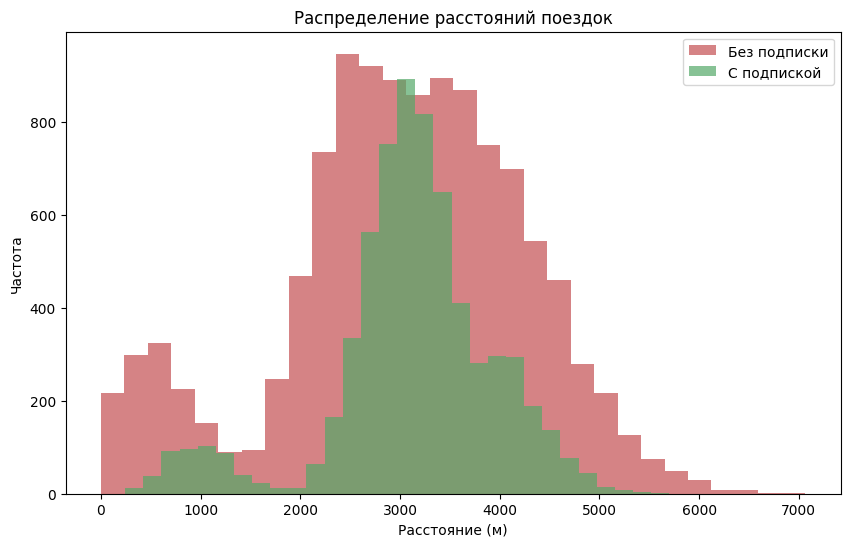

In [ ]:
# Визуализация данных о расстоянии поездок
plt.figure(figsize=(10, 6))
plt.hist(df_no_subs['distance'], bins=30, alpha=0.7, color="#c44e52", label="Без подписки")
plt.hist(df_with_subs['distance'], bins=30, alpha=0.7, color="#55a868", label="С подпиской")
plt.title("Распределение расстояний поездок")
plt.xlabel("Расстояние (м)")
plt.ylabel("Частота")
plt.legend()
plt.show()

Визуализация показывает, что пользователи с подпиской чаще совершают более длинные поездки по сравнению с пользователями без подписки. Распределение для обеих категорий имеет схожую форму, однако максимальная частота наблюдается на больших расстояниях у подписчиков.

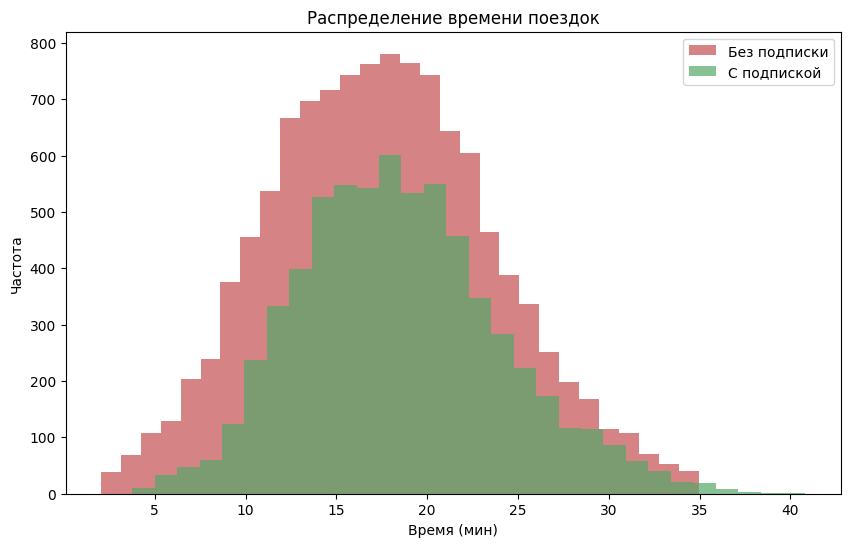

In [ ]:
# Визуализация данных о времени поездок
plt.figure(figsize=(10, 6))
plt.hist(df_no_subs['duration'], bins=30, alpha=0.7, color="#c44e52", label="Без подписки")
plt.hist(df_with_subs['duration'], bins=30, alpha=0.7, color="#55a868", label="С подпиской")
plt.title("Распределение времени поездок")
plt.xlabel("Время (мин)")
plt.ylabel("Частота")
plt.legend()
plt.show()

Распределение времени поездок показывает, что пользователи с подпиской совершают более длительные поездки по сравнению с пользователями без подписки, что отражается в правом сдвиге пика их распределения. Несмотря на схожесть форм распределений, пользователи без подписки чаще совершают более короткие поездки.

## Заключение

Обе визуализации свидетельствуют готовности использовать сервис GoFast при наличии подписки для более длительных и длительных поездок - подписка стимулирует более активное использование сервиса.

# Подсчёт выручки

In [ ]:
# Агрегация данных о поездках
df_revenue = df_merge.groupby(['user_id', 'month']).agg(
    total_distance=('distance', 'sum'),
    total_rides=('user_id', 'count'),
    total_duration=('duration', 'sum')
).reset_index()

# Отображаем агрегированный датафрейм
df_revenue

,user_id,month,total_distance,total_rides,total_duration
0,1,1,7027.511294,2,41.416640
1,1,4,754.159807,1,6.232113
2,1,8,6723.470560,2,44.776802
3,1,10,5809.911100,2,31.578017
4,1,11,7003.499363,3,53.397424
...,...,...,...,...,...
11295,1534,6,3409.468534,2,24.812678
11296,1534,8,7622.453034,2,47.205960
11297,1534,9,4928.173852,1,22.560373
11298,1534,11,13350.015305,4,76.342174


In [ ]:
# Округляем продолжительность каждой поездки до ближайшего большего целого
df_merge['duration'] = np.ceil(df_merge['duration'])

# Агрегируем помесячную выручку
df_revenue = df_merge.groupby(['user_id', 'month', 'subscription_type']).agg(
    total_distance=('distance', 'sum'),
    total_rides=('user_id', 'count'),
    total_duration=('duration', 'sum'),
    start_ride_price=('start_ride_price', 'mean'),  # Стоимость старта
    minute_price=('minute_price', 'mean'),          # Стоимость минуты
    subscription_fee=('subscription_fee', 'mean')   # Абонентская плата
).reset_index()

# Рассчитываем выручку
df_revenue['revenue'] = (
    df_revenue['start_ride_price'] * df_revenue['total_rides'] +
    df_revenue['minute_price'] * df_revenue['total_duration'] +
    df_revenue['subscription_fee']
)

# Отображаем обновленный датафрейм с выручкой
df_revenue

,user_id,month,subscription_type,total_distance,total_rides,total_duration,start_ride_price,minute_price,subscription_fee,revenue
0,1,1,ultra,7027.511294,2,42.0,0.0,6.0,199.0,451.0
1,1,4,ultra,754.159807,1,7.0,0.0,6.0,199.0,241.0
2,1,8,ultra,6723.470560,2,46.0,0.0,6.0,199.0,475.0
3,1,10,ultra,5809.911100,2,32.0,0.0,6.0,199.0,391.0
4,1,11,ultra,7003.499363,3,56.0,0.0,6.0,199.0,535.0
...,...,...,...,...,...,...,...,...,...,...
11295,1534,6,free,3409.468534,2,26.0,50.0,8.0,0.0,308.0
11296,1534,8,free,7622.453034,2,48.0,50.0,8.0,0.0,484.0
11297,1534,9,free,4928.173852,1,23.0,50.0,8.0,0.0,234.0
11298,1534,11,free,13350.015305,4,78.0,50.0,8.0,0.0,824.0


# Проверка гипотез

## Выгоднее ли пользователи с подпиской для компании?

*Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании.*

**Формулировка гипотез**
*   Нулевая гипотеза H0: Среднее время поездок у пользователей с подпиской МЕНЬШЕ, чем у пользователей без подписки.
*   Альтернативная гипотеза H1: Среднее время поездок у пользователей с подпиской БОЛЬШЕ,  чем у пользователей без подписки.

In [ ]:
# Уровень значимости
alpha = 0.05

# Данные о продолжительности поездок для пользователей с подпиской и без подписки
duration_with_subs = df_with_subs['duration']
duration_no_subs = df_no_subs['duration']

# Тестирование гипотезы
t_stat, p_value = ttest_ind(duration_with_subs, duration_no_subs, equal_var=False, alternative='greater')

# Отображение результатов
print(f't-статистика: {t_stat:.4f}')
print(f'p-значение: {p_value:.4e}')

# Проверка гипотезы
if p_value < alpha:
    print('Отвергаем нулевую гипотезу.')
else:
    print('Не отвергаем нулевую гипотезу.')

t-статистика: 11.2449
p-значение: 1.6162e-29
Отвергаем нулевую гипотезу.


**P-value** значительно меньше порога - нулевая гипотеза отвергается.

Это означает, что среднее время поездок пользователей с подпиской, чем у пользователей без подписки.

Данный результат подтверждает, что пользователи с подпиской могут быть "выгоднее" для компании с точки зрения времени, проведённого в поездках.

In [ ]:
# Вычисление средних значений для обеих групп
mean_duration_with_subs = round(duration_with_subs.mean(), 2)
mean_duration_no_subs = round(duration_no_subs.mean(), 2)

# Отображение результатов
print('Среднее время поездки пользователей с подпиской:', mean_duration_with_subs)
print('Среднее время поездки пользователей без подписки:', mean_duration_no_subs)

Среднее время поездки пользователей с подпиской: 18.54
Среднее время поездки пользователей без подписки: 17.53


## Расстояние, которое проезжают пользователи с подпиской превышает 3130 метров?

*Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?*

**Формулировка гипотез**
*   H0: Среднее расстояние, которое проезжают пользователи с подпиской, равно или меньше 3130 метров.
*   H1: Среднее расстояние превышает 3130 метров.

In [ ]:
# Данные о расстоянии поездок для пользователей с подпиской
distance_with_subs = df_with_subs['distance']

# Оптимальное расстояние
optimal_distance = 3130

# Проведение одновыборочного t-теста
t_stat, p_value = ttest_1samp(distance_with_subs, popmean=optimal_distance, alternative='greater')

# Вывод результатов
mean_distance_with_subs = round(distance_with_subs.mean(), 2)
print('Среднее расстояние поездки пользователей с подпиской:', mean_distance_with_subs)
print(f't-статистика: {t_stat:.4f}')
print(f'p-значение: {p_value:.4e}')

# Проверка гипотезы
if p_value < alpha:
    print('Отвергаем нулевую гипотезу.')
else:
    print('Не отвергаем нулевую гипотезу.')

Среднее расстояние поездки пользователей с подпиской: 3115.45
t-статистика: -1.4021
p-значение: 9.1954e-01
Не отвергаем нулевую гипотезу.


**P-value** значительно больше порога - нет оснований отвергнуть нулевую гипотезу.

Следовательно, можно утверждать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров.

## Ежемесячная выручка от пользователей с подпиской выше?

*Проверьте гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.*

**Формулировка гипотез**
*   H0: Средняя выручка от пользователей с подпиской равна или меньше выручки от пользователей без подписки.
*   H1: Средняя выручка от пользователей с подпиской больше.

In [ ]:
# Агрегируем выручку для пользователей с подпиской и без подписки без группировки по месяцам
revenue_with_subs_all = df_revenue[df_revenue['user_id'].isin(df_with_subs['user_id'])]['revenue']
revenue_no_subs_all = df_revenue[df_revenue['user_id'].isin(df_no_subs['user_id'])]['revenue']

# Преобразуем в массивы для сравнения
revenue_with_subs_values = revenue_with_subs_all.values
revenue_no_subs_values = revenue_no_subs_all.values

# Проведение одностороннего t-теста
t_stat, p_value = ttest_ind(revenue_with_subs_values, revenue_no_subs_values, alternative='greater', equal_var=False)

# Результаты теста
print(f't-статистика: {t_stat:.4f}')
print(f'p-значение: {p_value:.4e}')

# Проверка гипотезы
if p_value < alpha:
    print('Отвергаем нулевую гипотезу.')
else:
    print('Не отвергаем нулевую гипотезу.')

t-статистика: 12.9440
p-значение: 2.4970e-38
Отвергаем нулевую гипотезу.


**P-value** значительно меньше порога - нулевая гипотеза отвергается.

Следовательно, можно утверждать, что помесячная выручка от пользователей с подпиской действительно выше, чем от пользователей без подписки.

In [ ]:
# Вычисление средних значений для обеих групп выручки
mean_revenue_with_subs = round(revenue_with_subs_all.mean(), 2)
mean_revenue_no_subs = round(revenue_no_subs_all.mean(), 2)

# Отображение результатов
print('Средняя выручка от пользователей с подпиской:', mean_revenue_with_subs)
print('Средняя выручка от пользователей без подписки:', mean_revenue_no_subs)

Средняя выручка от пользователей с подпиской: 362.79
Средняя выручка от пользователей без подписки: 329.33


## Тест для проверки гипотезы о снижении количества обращений в техподдержку

*Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?*

Для проверки гипотезы о снижении количества обращений в техподдержку после обновления серверов потребуется t-тест для зависимых выборок (парный t-тест) - данные до и после обновления серверов принадлежат одним и тем же пользователям, а значит, выборки зависят друг от друга. Следует использовать метод `scipy.stats.ttest_rel`.

## Заключение
В результате проверки гипотез установлено, что пользователи с подпиской проводят больше времени в поездках - это делает их более выгодными для компании, а их среднее расстояние за поездку не превышает оптимального уровня износа самоката в 3130 метров. Также выяснено, что помесячная выручка от подписчиков значимо выше, чем от пользователей без подписки - это подтверждает их коммерческую ценность.

# Распределения

## Акция с раздачей промокодов

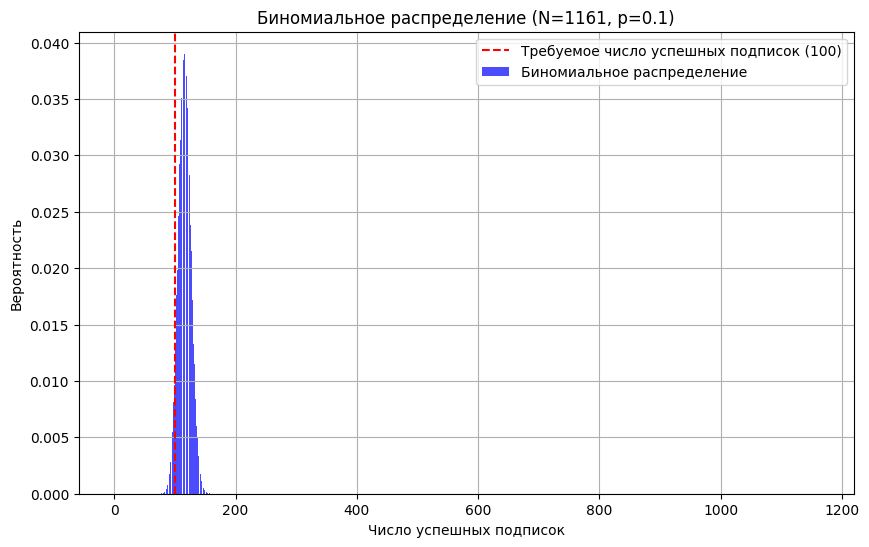

In [ ]:
# Заданные параметры
p = 0.1  # Вероятность продления подписки
required_successes = 100  # Требуемое число пользователей, которые продлят подписку
alpha = 0.05  # Допустимая вероятность не выполнить план (уровень значимости)

# Перебор значений N для поиска минимального количества промокодов
for N in range(1000, 10000):
    # Вычисляем вероятность получить меньше 100 успешных подписок
    probability = binom.cdf(required_successes - 1, N, p)
    if probability <= alpha:
        min_promocodes = N
        break

# Построение графика распределения для найденного значения N
x = np.arange(0, min_promocodes + 1)
y = binom.pmf(x, min_promocodes, p)

plt.figure(figsize=(10, 6))
plt.bar(x, y, alpha=0.7, color='blue', label='Биномиальное распределение')
plt.axvline(required_successes, color='red', linestyle='--', label='Требуемое число успешных подписок (100)')
plt.title(f"Биномиальное распределение (N={min_promocodes}, p={p})")
plt.xlabel('Число успешных подписок')
plt.ylabel('Вероятность')
plt.legend()
plt.grid()
plt.show()

Для достижения вероятности выполнения плана (не менее 100 продлений подписки) с уровнем значимости 5% необходимо разослать **1161** промокод.

## Оценка вероятности открытия push-уведомлений

Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

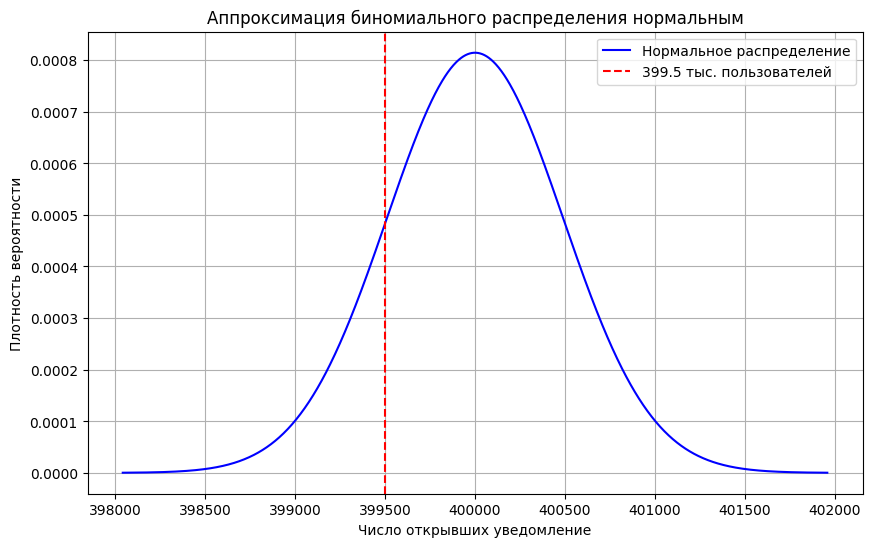

0.15371708296369768

In [ ]:
# Параметры задачи
n = 1_000_000  # Количество уведомлений
p = 0.4  # Вероятность открытия одного уведомления
mean = n * p  # Математическое ожидание (среднее)
std = np.sqrt(n * p * (1 - p))  # Стандартное отклонение

# Нормальная аппроксимация
x = np.linspace(mean - 4 * std, mean + 4 * std, 1000)
y = norm.pdf(x, loc=mean, scale=std)

# Вероятность того, что уведомления откроют не более 399.5 тыс. пользователей
probability = norm.cdf(399_500, loc=mean, scale=std)

# Построение графика распределения
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='Нормальное распределение', color='blue')
plt.axvline(399_500, color='red', linestyle='--', label='399.5 тыс. пользователей')
plt.title("Аппроксимация биномиального распределения нормальным")
plt.xlabel("Число открывших уведомление")
plt.ylabel("Плотность вероятности")
plt.legend()
plt.grid()
plt.show()

probability

Вероятность того, что уведомление откроют не более 399,5 тысяч пользователей, составляет примерно 15.37%. График демонстрирует нормальную аппроксимацию биномиального распределения.

## Заключение
В рамках анализа распределений определено, что для достижения планового количества продлений подписки (100 пользователей) с вероятностью выполнения задачи 95 % необходимо разослать минимум 1161 промокод. Также установлено, что вероятность того, что менее 399,5 тысяч из 1 миллиона разосланных push-уведомлений будут открыты, составляет около 15.37 %.

# Общее заключение по проекту

В рамках проекта были последовательно выполнены этапы анализа и обработки данных, а также проверки гипотез, что позволило получить следующие ключевые выводы:

*   **Загрузка данных и подготовка их к анализу**: Были загружены и обработаны три датафрейма с данными о пользователях, поездках и подписках. Данные в целом не содержали пропусков, однако в таблице `df_users` были выявлены и устранены дубликаты. Проведена обработка временных данных и добавление необходимых атрибутов для дальнейшего анализа.

*   **Исследовательский анализ данных**: Выявлены основные демографические и поведенческие характеристики пользователей. Большинство клиентов предпочитают использовать сервис без подписки, но значительная доля пользователей с подпиской указывает на её востребованность. Основной возрастной группой пользователей являются молодые люди 20–30 лет, а типичная поездка длится 15–20 минут и покрывает около 3 км.

*   **Объединение данных**: Анализ объединённых данных подтвердил, что наличие подписки стимулирует клиентов к более активному использованию сервиса, включая увеличение длительности поездок. Это свидетельствует о положительном влиянии подписок на вовлечённость пользователей.

*   **Проверка гипотез**: Установлено, что пользователи с подпиской проводят в поездках больше времени, что делает их более ценными с точки зрения выручки. Средняя дистанция поездок подписчиков не превышает оптимального уровня износа оборудования. Выручка от подписчиков значительно превышает доходы от пользователей без подписки, что подчёркивает их коммерческую важность.

*   **Анализ распределений**: Для достижения целевых показателей маркетинговых кампаний рассчитано необходимое количество рассылок. Например, для привлечения 100 пользователей необходимо разослать не менее 1161 промокод. Анализ push-уведомлений показал вероятность 15,37 % уровня открытия сообщений, что может быть учтено при планировании стратегии взаимодействия с клиентами.

### **Выводы**:
Пользователи с подпиской проводят в среднем больше времени на поездках (18,5 мин), чем пользователи без подписки (17,3 мин), что делает их более выгодными для компании. Средняя месячная выручка от подписчиков также выше (362,79) по сравнению с пользователями без подписки (328,64).

### **Рекомендации**:
*   **Увеличить привлекательность подписки**: Поскольку пользователи с подпиской тратят больше времени на поездки, увеличивая выручку, стоит усилить маркетинговые усилия, направленные на привлечение новых подписчиков, предлагая дополнительные бонусы или улучшения в сервисе.

*   **Оптимизация тарифных планов**: Учитывая, что средняя дистанция поездок не превышает оптимального уровня износа, можно рассмотреть возможность создания дополнительных тарифных планов или акций для повышения частоты использования самокатов.

*   **Фокус на молодых пользователях**: Поскольку основная аудитория — это молодые люди 20-30 лет, можно направить маркетинговые усилия на улучшение сервиса для этой возрастной группы, например, через партнерства с учебными заведениями или вузы.

*   **Улучшение взаимодействия через уведомления**: Учитывая низкий уровень открытия push-уведомлений (15,37%), необходимо оптимизировать сообщения, улучшить таргетинг и повысить привлекательность уведомлений для увеличения их эффективности.

*   **Оптимизация маркетинговых рассылок**: Для привлечения новых пользователей важно увеличить количество рассылок, исходя из рассчитанных потребностей, например, отправлять 1161 промокод для достижения цели привлечения 100 новых клиентов.